In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
import saopaulo.cycling_potential as cp
import saopaulo.choropleth as choro
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString
import ast
from random import randint

from math import floor

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time
import scipy.stats as st

# read routes files and join with general trips file
od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/DEINFO_REGIAO8.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

routes_car = pd.read_csv('../data/sao-paulo/rotas-migracao/new_routes_cars.csv')
routes_car.set_index('trip_id', inplace=True, drop=False)
routes_car = routes_car.join(other = od_trips, how = 'left')
routes_car = gpd.GeoDataFrame(routes_car, crs={'init': 'epsg:4326'}, 
                              geometry=[LineString(ast.literal_eval(r)) for r in routes_car.route])
routes_car['length'] = routes_car['geometry'].length * 100000

the_grid = gr.create(n=9, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
regions = {   
    "sul1": [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 
             66, 67, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 
             248, 249, 250, 251, 252, 273, 274, 275, 276],
    "sul2": [268, 269, 270, 271, 272, 277, 278, 279, 280, 281, 282, 283, 284, 285, 
             286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 
             300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 
             314, 315, 320, 321, 322, 323, 324, 325, 326],
    "norte1": [109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
               124, 125, 126, 127, 136, 137, 138, 139, 140, 141, 142, 143],
    "norte2": [128, 129, 130, 131, 132, 133, 134, 135, 144, 145, 146, 147, 148, 149, 150, 
               151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165],
    "centro": [1, 2, 3, 4, 5, 6, 7, 8, 9, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
               30, 31, 32, 33, 34, 35, 36, 37],
    "oeste": [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 
              87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 
              105, 106, 107, 108, 113, 316, 317, 318, 319, 327, 328, 329, 330, 331, 332, 333,
              334, 335, 336, 337, 338, 339, 340, 341, 342],
    "leste1": [10, 11, 12, 13, 14, 15, 16, 17, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 166, 167, 
               168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 208, 209, 210, 211, 212, 213,
               214, 215, 216, 217, 218, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263],
    "leste2": [179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 
               195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 219, 220, 221, 
               222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 264, 265, 266, 267]
}

In [3]:
def plot_route_potential (id_route):
    r = routes_car.loc[routes_car['ID_ORDEM'] == id_route].iloc[0]
    r_split = split_route(r['geometry'], 10)
    
    fmap = gr.map_around_sp(the_grid=None,zoom=15,plot_grid=False)
    plot_slope(fmap, r['geometry'], 'line')
    display(fmap)
    

    heights = [line[0].coords[0][2] for line in r_split]
    slopes = [line[1] for line in r_split]
    lengths = [i * 10 for i in range(len(heights))]

    plt.figure(figsize=(15,5))
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (metros)')
    plt.xlabel('metros')
    #plt.savefig('../pagina_web/images/altitude_' + r['ID_ORDEM'])
    plt.show()

    pos_s = []
    for s in slopes:
        if s > 0:
            pos_s.append(s)
    plt.figure(figsize=(15,5))
    plt.hist(bins=range(1, round(max(pos_s)) + 1),x=[round(s) for s in pos_s], weights = [10]*len(pos_s))
    plt.title('Metros percorridos em cada inclinação)')
    plt.xlabel('declividade')
    plt.ylabel('metros percorridos')
    #plt.savefig('../pagina_web/images/inclinacao_' + r['ID_ORDEM'])
    plt.show()

    pot = cp.cycling_potential_variables(r)
    print('Distance potential:    ', pot[0], '\tDistance: ', r['length'])
    print('Age potential:         ', pot[1], '\tAge:      ', r['IDADE'])
    print('Inclination potential: ', pot[2])
    print('\nGender:')
    print('1 = M, 2 = F           ', r['SEXO'])

In [4]:
def generate_images (route, trip_id):
    r_split = split_route(route, 10)

    heights = [line[0].coords[0][2] for line in r_split]
    slopes = [line[1] for line in r_split]
    lengths = [i * 10 for i in range(len(heights))]

    plt.figure(figsize=(15,5))
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (metros)')
    plt.xlabel('metros')
    #plt.axis('scaled')
    plt.ylim(700, 900)
    plt.savefig('../pagina_web/images/altitude_' + trip_id)
    #plt.show()

    slopes_positive = []
    for s in slopes:
        if round(s) > 0:
            slopes_positive.append(round(s))
        else:
            slopes_positive.append(0)
    plt.figure(figsize=(15,5))
    plt.hist(bins=range(0, round(max(slopes)) + 1),
             x=slopes_positive, weights = [10]*len(slopes_positive))
    plt.title('Metros percorridos em cada nível de inclinação')
    plt.xlabel('inclinação (%)')
    plt.ylabel('metros percorridos')
    plt.savefig('../pagina_web/images/inclinacao_' + trip_id)
    
def distance_per_inclination (route):
    r_split = split_route(route, 10)
    slopes = [line[1] for line in r_split]
    slopes_incl = [0,0,0,0,0]
    for s in slopes:
        if round(s) <= 0:
            slopes_incl[0] += 10
        elif round(s) <= 3:
            slopes_incl[1] += 10
        elif round(s) <= 5:
            slopes_incl[2] += 10
        elif round(s) <= 7:
            slopes_incl[3] += 10
        else:
            slopes_incl[4] += 10        
    return slopes_incl
    
def color_inclination (i):
        if i > 7:
            return 'black'
        elif i > 5:
            return '#982123'
        elif i > 3:
            return '#D03F2E'
        elif i > 1:
            return '#F1C359'
        elif i > -1:
            return 'yellow'
        elif i > -3:
            return '#94C280'
        elif i > -5:
            return '#0C9CB4'
        else:
            return '#025189'
    
def route_to_json (route):
    json = """
    {
        "id": " """ + str(int(route['trip_id'])) + """ ",
        "distance": " """ + str(round(route['geometry'].length * 100000)) + """ " , """
    dists = distance_per_inclination(route['geometry'])
    for i in range(len(dists)):
        json += """ "distance_""" + str(i) + """\" : " """ + str(dists[i]) + """ ", """
    json += """
        "route":
        [
    """
    stretchs_slope = split_route(route['geometry'], 100, False)
    for s in stretchs_slope:
        json += \
            """
    {
        "type": "Feature",
        "properties": {
            "color": " """ + color_inclination(s[1]) + """ "
        },
        "geometry": {
            "type": "LineString",
            "coordinates": 
            [
            """
        for p in range(len(s[0].coords)):
            json += '[' + str(s[0].coords[p][0]) + ', ' + str(s[0].coords[p][1]) + ']'
            if (p < len(s[0].coords)):
                json += ','
            json += '\n'

        json += '] \n } \n },'
    json += '\n ] }'
    return json

def save_routes_json(nome, ids):
    json = 'var routes_' + nome + ' = ['
    for i in ids:
        route = routes_car.loc[routes_car['ID_ORDEM'] == i].iloc[0]
        json += route_to_json (route) + ','
    json += ']'
    with open(nome + ".js", "w") as text_file:
        text_file.write(json)

def save_image(ids):
    for i in ids:
        route = routes_car.loc[routes_car['ID_ORDEM'] == i].iloc[0]
        generate_images (route['geometry'], str(i))

In [5]:
save_routes_json("sul1", [24500, 89200, 95400, 19502, 102056])
save_routes_json("sul2", [102603, 103903, 118800, 118553, 105606])
save_routes_json("leste1", [76450, 67802, 16753, 79756, 77457])
save_routes_json("leste2", [82350, 73402, 93304, 69406, 74407])
save_routes_json("centro", [13450, 13202, 760, 884, 523])
save_routes_json("oeste", [121350, 121452, 45353, 37903, 35004])
save_routes_json("norte1", [50150, 50602, 56553, 50889, 57296])
save_routes_json("norte2", [60750, 54452, 54853, 54632, 57616])

In [6]:
def filter_potential_widgets():
    # transform the lambda code in string, so we can pass as a string widget
    #pass the parameters as hidden widgets
    im = interact_manual(
        filter_potential,
        total_potential = widgets.FloatRangeSlider(
            value=[0.9, +1.],
            min=0, max=1., step=0.05,
            description='Final Potential:\t'
        ),
        distance_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Distance Potential:\t'
        ),
        inclination_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Inclination Potential:\t'
        ),
        age_potential = widgets.FloatRangeSlider(
            value=[0, +1.],
            min=0, max=1., step=0.05,
            description='Age Potential:\t'
        ),
        region = widgets.Dropdown(options = [('Norte 1', 'norte1'), ('Norte 2', 'norte2'), ('Oeste', 'oeste'),  
                                            ('Centro', 'centro'), ('Leste 1', 'leste1'), ('Leste 2', 'leste2'),
                                            ('Sul 1', 'sul1'), ('Sul 2', 'sul2')], 
                                 description = 'Região'),        
        plot_map = widgets.Checkbox(value=True, description = 'Gerar mapa')
    )
    im.widget.children[6].description = 'Filtrar viagens'

def plot_filter_trips(df):
    fmap = gr.map_around_sp(the_grid=None,zoom=10,plot_grid=False)
    
    folium.GeoJson(zone_shp,
                   style_function = lambda x : {'color': 'black', 'weight': 1, 'opacity': 1, 
                                                'fillOpacity': 0},
                   name='Zonas', control=False).add_to(fmap)
    
    for _, r in df.iterrows():
        try:
            plot_slope(fmap, r['geometry'], 100)
            tooltip_route=folium.features.Tooltip(text = ' id:\t' + str(r['trip_id']) + 
                                                  '\n fe_via:\t' + str(r['fe_via']) + 
                                                  '\n distance:\t' + str(round(r['geometry'].length * 100000)) +
                                                  '\n sexo:\t' + str(r['sexo']))
            folium.GeoJson(r['geometry'],
                           style_function = lambda x : {'opacity': 0, 'fillOpacity': 0},
                           tooltip = tooltip_route).add_to(fmap)
        except:
            print(_)
    display(fmap)
    
    
def filter_potential(total_potential, distance_potential, age_potential, inclination_potential, 
                     region, plot_map = False):
    cp_list = []
    for i, r in routes_car.iterrows():
        if ((r['ZONA_O'] in regions[region] and r['ZONA_D'] in regions[region])
           and r['geometry'].length > 0.005 and r['geometry'].length < 0.09):
            
            pot_d, pot_a, pot_i = cp.cycling_potential_variables(r)
            cp_list.append(['car', i, pot_d, pot_a, pot_i, 0, r['FE_VIA'], r['SEXO'], r['geometry']])

    columns = ['modal', 'trip_id', 'distance_potential', 'age_potential', 'inclination_potential', 'is_bike', 'fe_via', 'sexo', 'geometry']
    aux = pd.DataFrame(data = cp_list, columns = columns)

    aux['total'] = (aux['age_potential'] + aux['distance_potential'] + aux['inclination_potential']) / 3
    aux = aux.loc[aux['age_potential'] >= age_potential[0]]
    aux = aux.loc[aux['age_potential'] <= age_potential[1]]
    aux = aux.loc[aux['distance_potential'] >= distance_potential[0]]
    aux = aux.loc[aux['distance_potential'] <= distance_potential[1]]
    aux = aux.loc[aux['inclination_potential'] >= inclination_potential[0]]
    aux = aux.loc[aux['inclination_potential'] <= inclination_potential[1]]
    aux = aux.loc[aux['total'] >= total_potential[0]]
    aux = aux.loc[aux['total'] <= total_potential[1]]
    
    if plot_map:
        plot_filter_trips(aux)
        
    return aux

In [7]:
filter_potential_widgets()

interactive(children=(FloatRangeSlider(value=(0.9, 1.0), description='Final Potential:\t', max=1.0, step=0.05)…

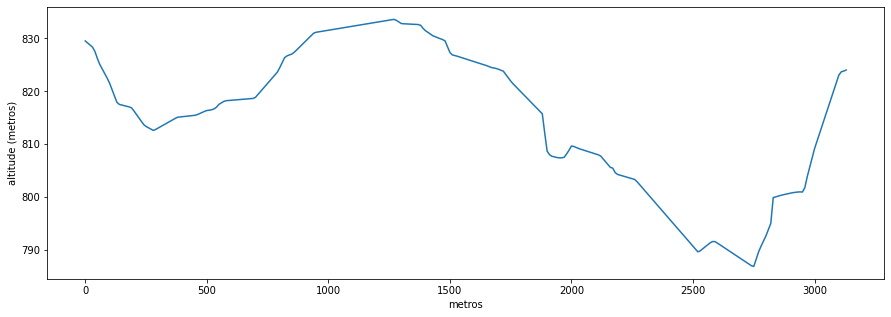

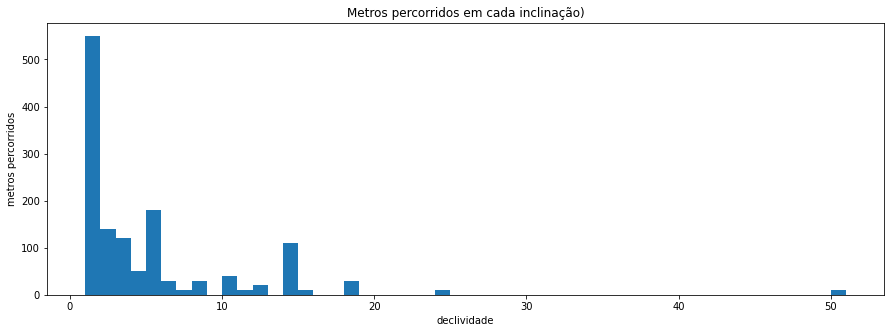

Distance potential:     0.6479556991021586 	Distance:  3130.1326810959795
Age potential:          0.9063861316747709 	Age:       39
Inclination potential:  0.40892189924836964

Gender:
1 = M, 2 = F            1


In [8]:
plot_route_potential (94610)
#[74750, 63850, 41500, 102550, 43650, 123450, 76450, 24500]

In [9]:
# 0: bad
# 1: medium
# 2: good

def get_random_route (region, distance_pot, inclination_pot, plot = True, n = 1):
    potentials = [(0, 0.35), (0.35, 0.65), (0.65, 1)]
    
    aux = filter_potential((0,1), potentials[distance_pot], (0,1),
                           potentials[inclination_pot], region, False)
    
    sample = aux.sample(n)
    if plot:
        display(sample)
        plot_filter_trips(sample)
    return sample

def get_sample_routes(region):
    r1 = get_random_route(region, 0, 0, False)
    r2 = get_random_route(region, 0, 2, False)
    r3 = get_random_route(region, 1, 1, False)
    r4 = get_random_route(region, 2, 0, False)
    r5 = get_random_route(region, 2, 2, False)
    
    sample = pd.concat([r1, r2, r3, r4, r5])
    
    display(sample)
    plot_filter_trips(sample)
    return sample

In [16]:
get_random_route('norte1', 2, 0, True, 5)

modal  trip_id  distance_potential  age_potential  inclination_potential  \
510   car  56835.0            0.924358       0.789277               0.152930   
144   car  49610.0            0.792839       0.173652               0.249805   
244   car  51818.0            0.808014       0.536977               0.329759   
677   car  52060.0            0.732402       0.153918               0.277917   
430   car  55747.0            0.749431       0.880418               0.293965   

     is_bike      fe_via  sexo  \
510        0  359.880479     1   
144        0  312.177110     1   
244        0  506.981741     1   
677        0  408.014466     2   
430        0   43.537468     1   

                                              geometry     total  
510  LINESTRING Z (-46.65208 -23.487195 737.49, -46...  0.622188  
144  LINESTRING Z (-46.720826 -23.437042 828.559999...  0.405432  
244  LINESTRING Z (-46.666785 -23.471119 749.98, -4...  0.558250  
677  LINESTRING Z (-46.689128 -23.482408 757.27, -4...  0.388079  
430  LINESTRING Z (-46.686414 -23.506027 728.29, -4...  0.641271

modal  trip_id  distance_potential  age_potential  inclination_potential  \
510   car  56835.0            0.924358       0.789277               0.152930   
144   car  49610.0            0.792839       0.173652               0.249805   
244   car  51818.0            0.808014       0.536977               0.329759   
677   car  52060.0            0.732402       0.153918               0.277917   
430   car  55747.0            0.749431       0.880418               0.293965   

     is_bike      fe_via  sexo  \
510        0  359.880479     1   
144        0  312.177110     1   
244        0  506.981741     1   
677        0  408.014466     2   
430        0   43.537468     1   

                                              geometry     total  
510  LINESTRING Z (-46.65208 -23.487195 737.49, -46...  0.622188  
144  LINESTRING Z (-46.720826 -23.437042 828.559999...  0.405432  
244  LINESTRING Z (-46.666785 -23.471119 749.98, -4...  0.558250  
677  LINESTRING Z (-46.689128 -23.482408 757.27, -4...  0.388079  
430  LINESTRING Z (-46.686414 -23.506027 728.29, -4...  0.641271

In [17]:
get_sample_routes('leste2')

modal  trip_id  distance_potential  age_potential  inclination_potential  \
848    car  83077.0            0.162678       0.980961               0.051905   
97     car  68332.0            0.146871       0.929678               0.657764   
1254   car  74979.0            0.521084       0.605983               0.532121   
1514   car  94252.0            0.802669       0.464619               0.301054   
126    car  69235.0            0.854313       0.720428               0.765611   

      is_bike      fe_via  sexo  \
848         0  305.836596     1   
97          0  185.203382     1   
1254        0  845.017228     2   
1514        0  327.297973     1   
126         0  222.113474     1   

                                               geometry     total  
848   LINESTRING Z (-46.426566 -23.563273 780.570000...  0.398515  
97    LINESTRING Z (-46.465877 -23.51368 780.64, -46...  0.578104  
1254  LINESTRING Z (-46.397994 -23.509681 785.47, -4...  0.553063  
1514  LINESTRING Z (-46.496193 -23.579593 754.42, -4...  0.522781  
126   LINESTRING Z (-46.460547 -23.486958 731.21, -4...  0.780117

modal  trip_id  distance_potential  age_potential  inclination_potential  \
848    car  83077.0            0.162678       0.980961               0.051905   
97     car  68332.0            0.146871       0.929678               0.657764   
1254   car  74979.0            0.521084       0.605983               0.532121   
1514   car  94252.0            0.802669       0.464619               0.301054   
126    car  69235.0            0.854313       0.720428               0.765611   

      is_bike      fe_via  sexo  \
848         0  305.836596     1   
97          0  185.203382     1   
1254        0  845.017228     2   
1514        0  327.297973     1   
126         0  222.113474     1   

                                               geometry     total  
848   LINESTRING Z (-46.426566 -23.563273 780.570000...  0.398515  
97    LINESTRING Z (-46.465877 -23.51368 780.64, -46...  0.578104  
1254  LINESTRING Z (-46.397994 -23.509681 785.47, -4...  0.553063  
1514  LINESTRING Z (-46.496193 -23.579593 754.42, -4...  0.522781  
126   LINESTRING Z (-46.460547 -23.486958 731.21, -4...  0.780117

In [12]:
centro = [8909, 3858, 34660, 19500, 11294]
sul1 = [94705, 8562, 86579, 19346, 89158] 
sul2 = [95217, 117543, 108672, 102561, 96214] 
leste1 = [76232, 76812, 17402, 75953, 91429] 
leste2 = [80204, 75324, 82083, 71464, 67350] 
norte1 = [49994, 56684, 56572, 53065, 51269] 
norte2 = [58631, 61798, 62482, 54576, 60744]
oeste = [42535, 46177, 121940, 30157, 124281]

In [13]:
save_routes_json("sul1", sul1)
save_routes_json("sul2", sul2)
save_routes_json("leste1", leste1)
save_routes_json("leste2", leste2)
save_routes_json("centro", centro)
save_routes_json("oeste", oeste)
save_routes_json("norte1", norte1)
save_routes_json("norte2", norte2)

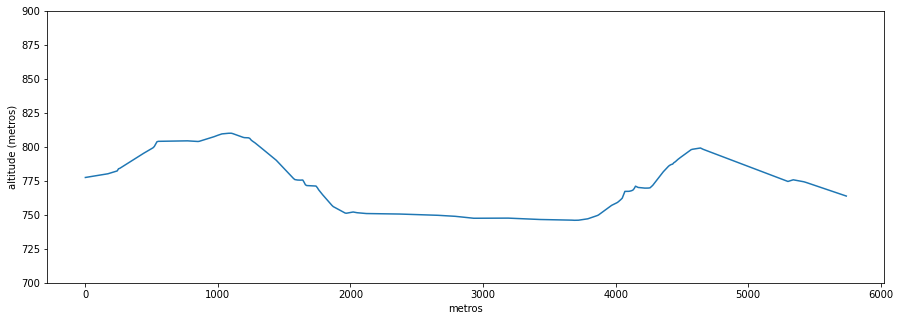

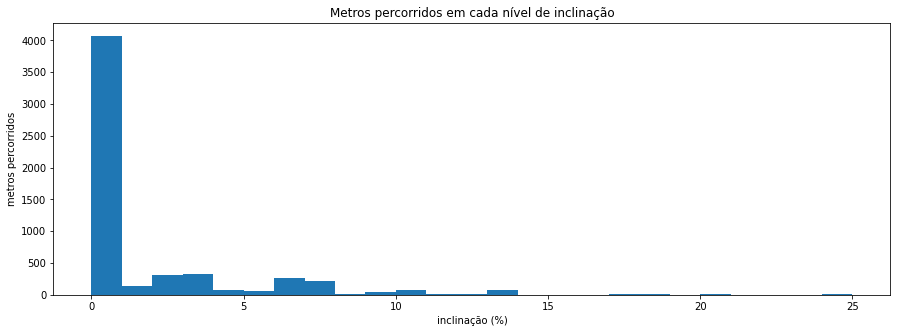

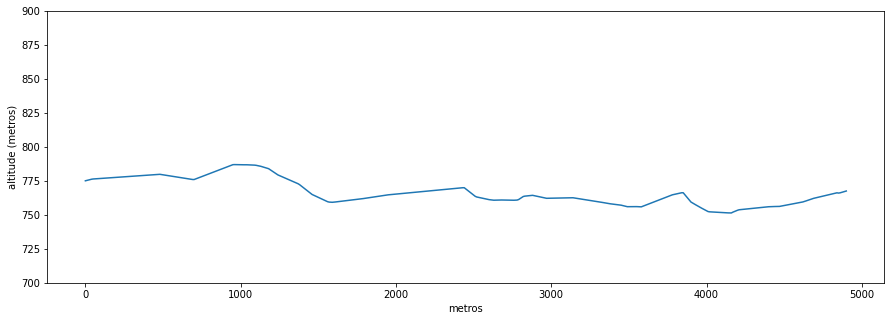

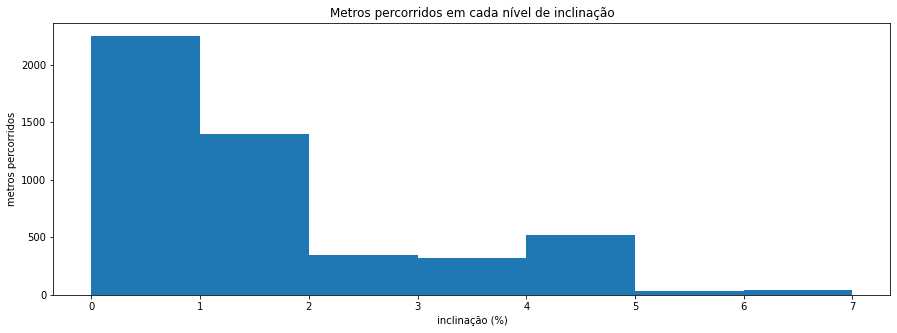

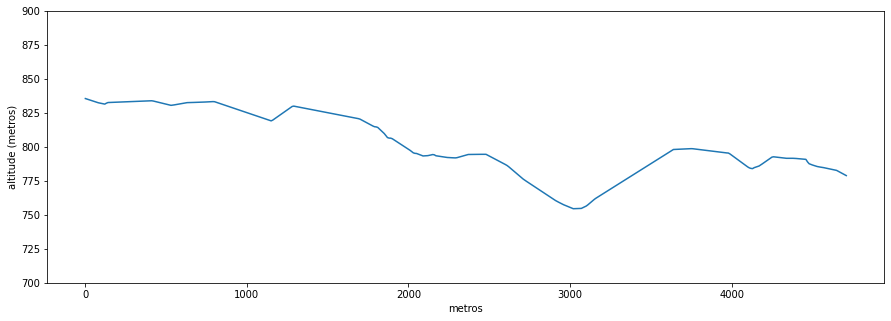

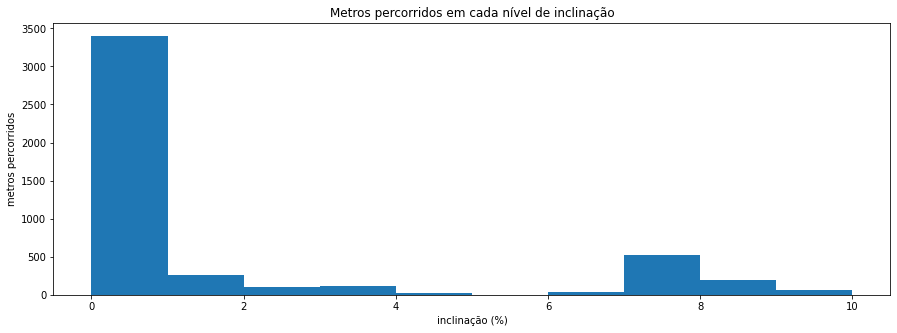

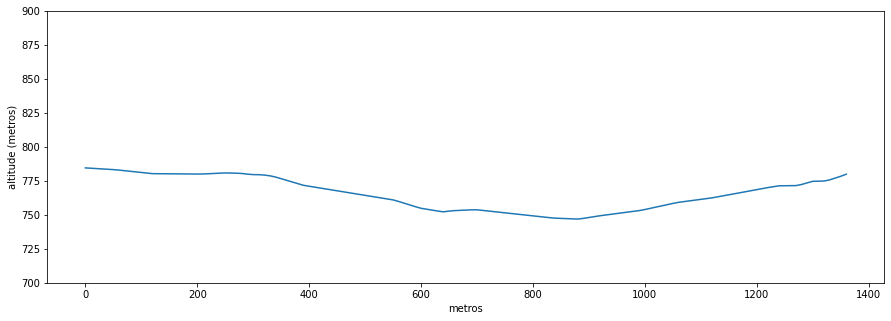

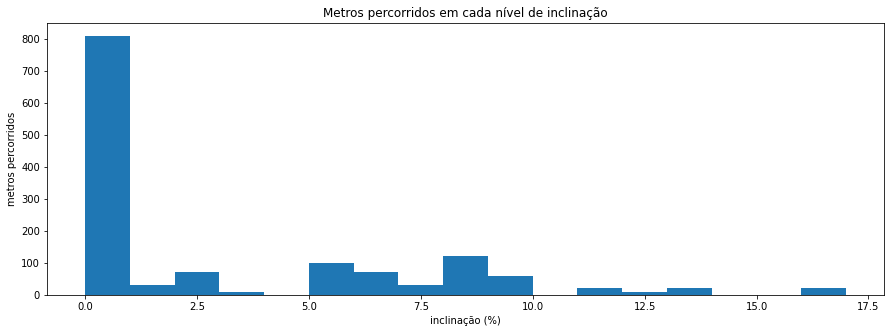

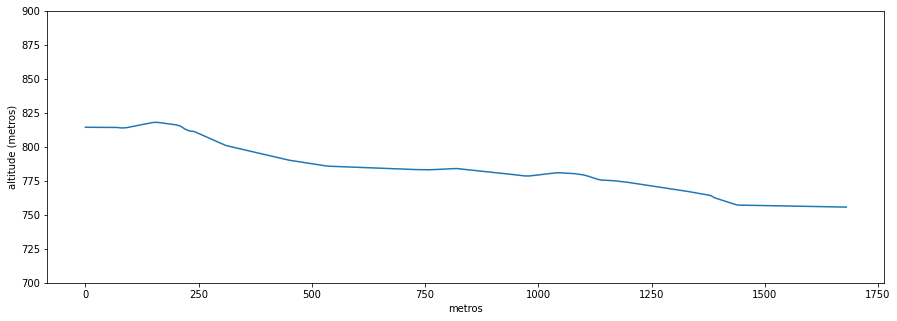

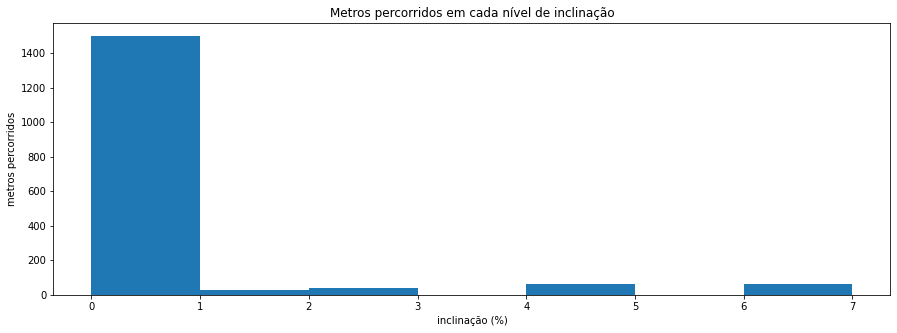

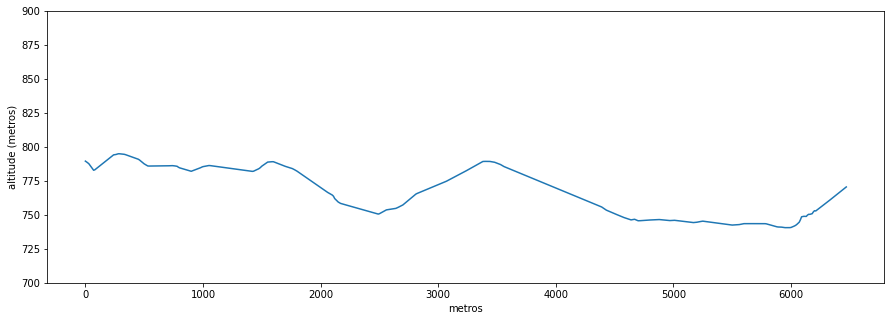

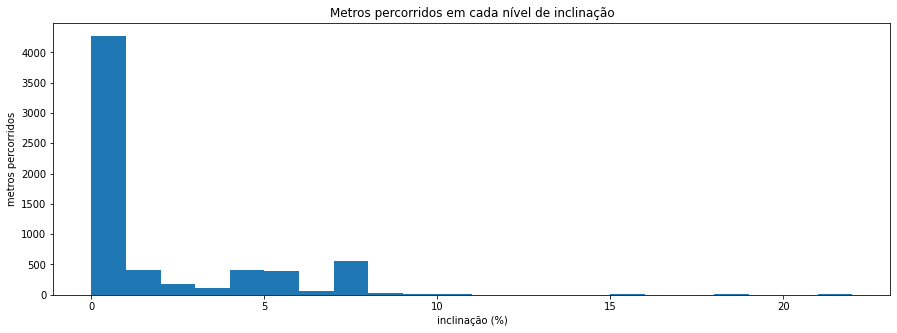

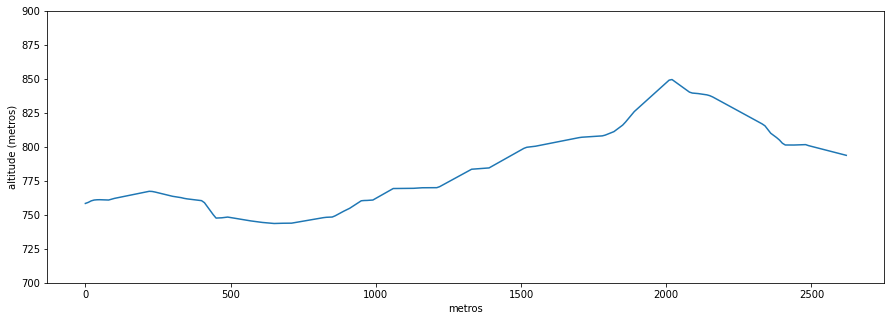

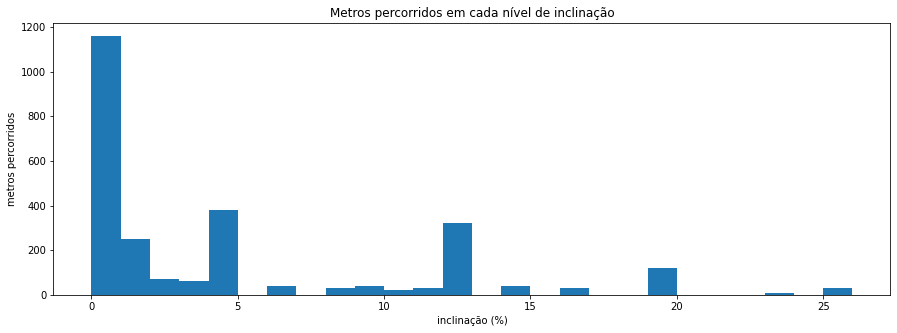

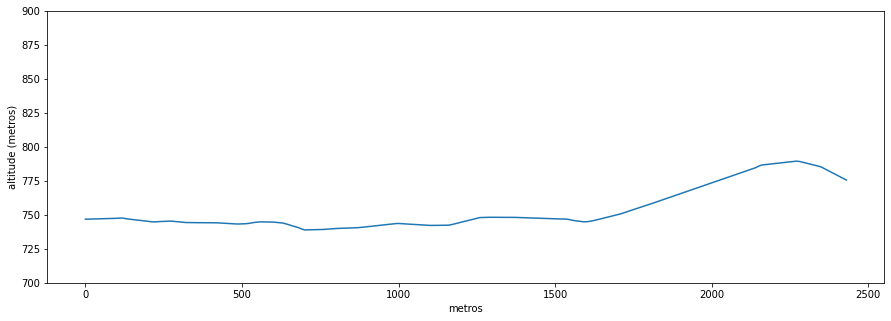

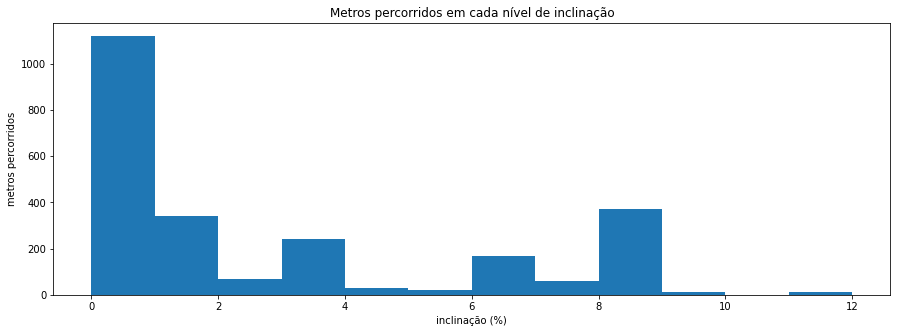

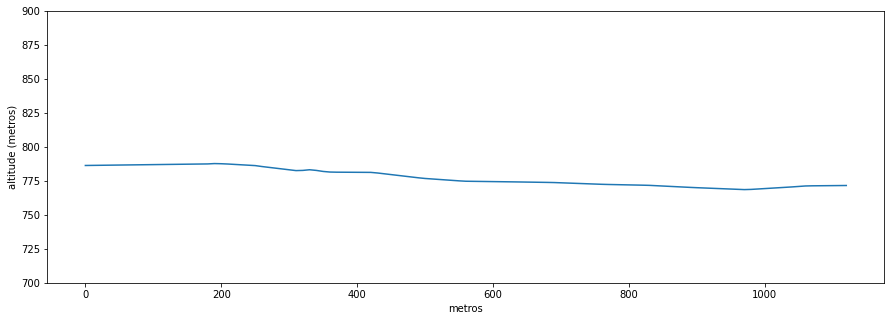

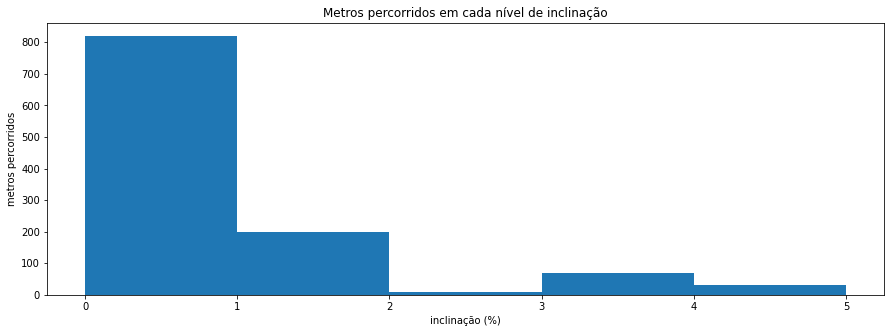

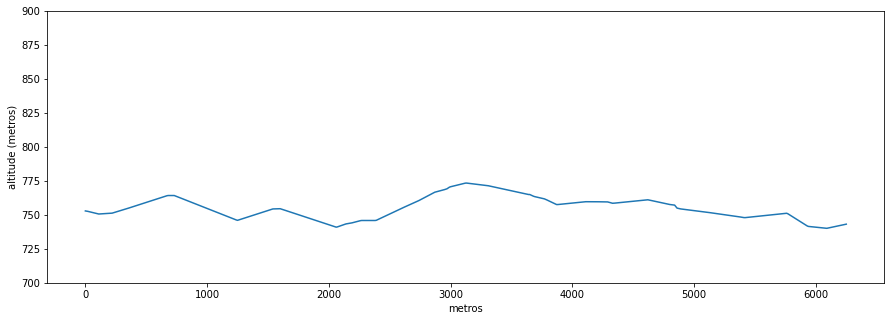

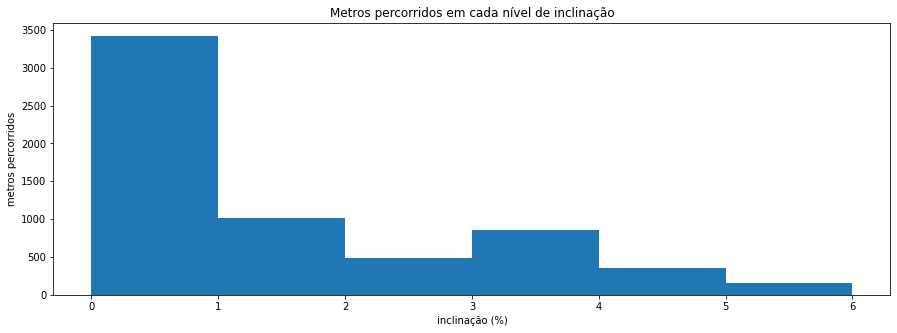

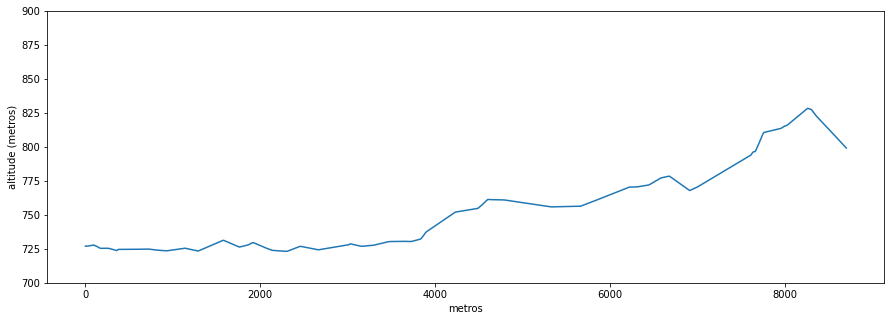

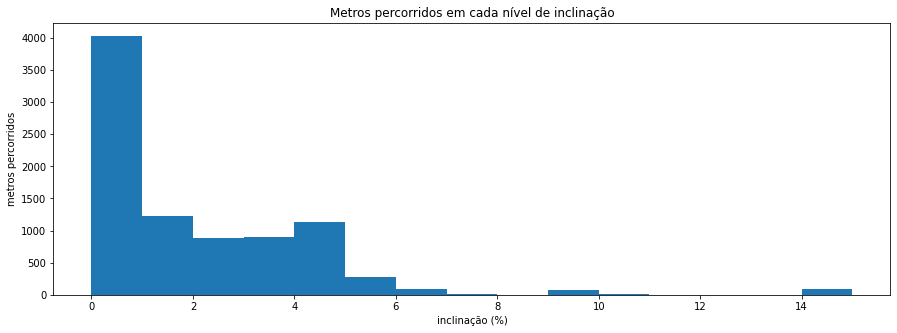

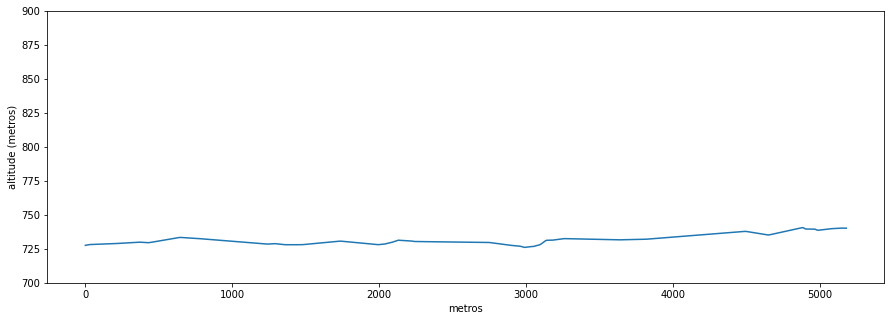

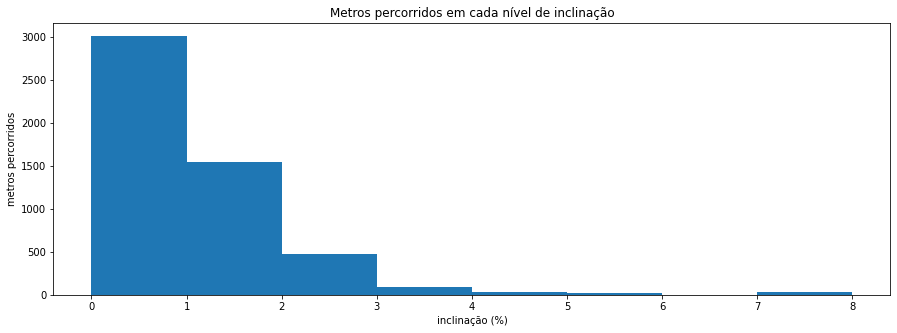

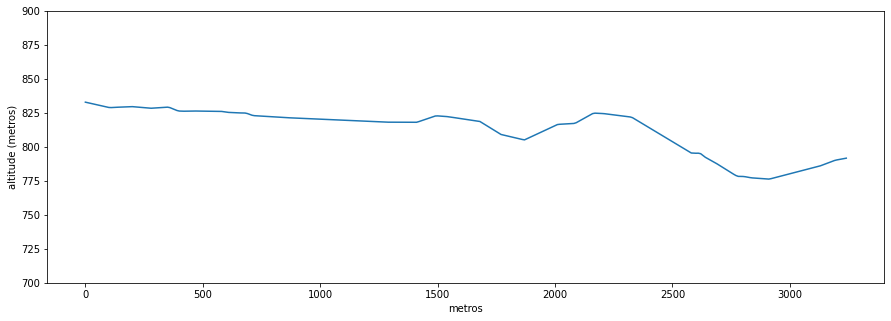

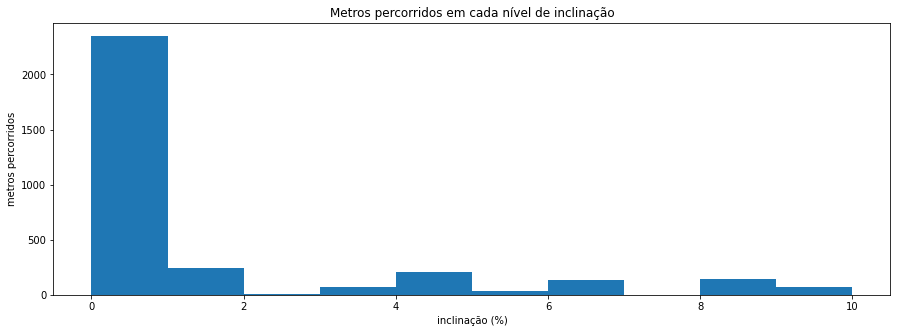

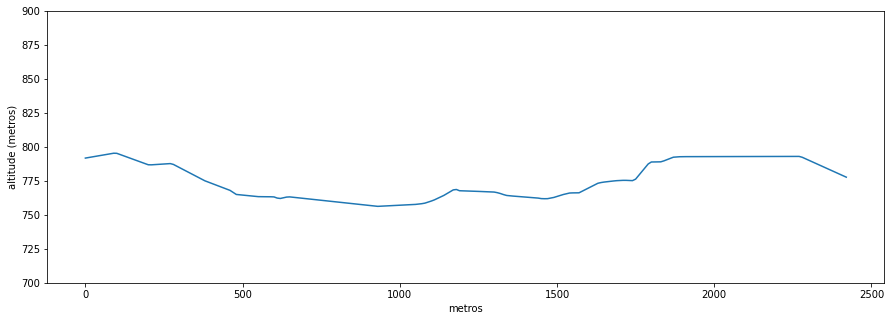

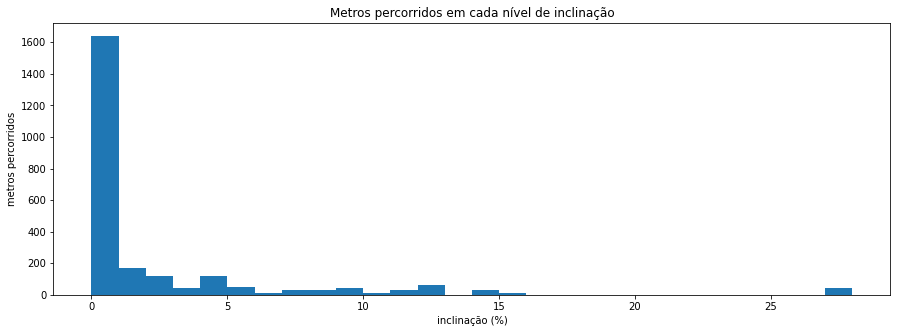

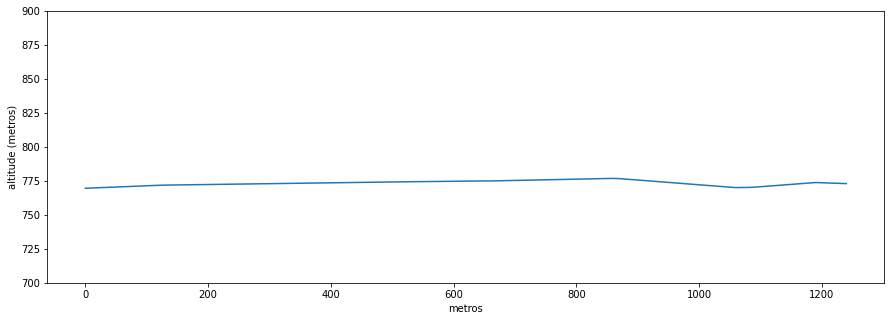

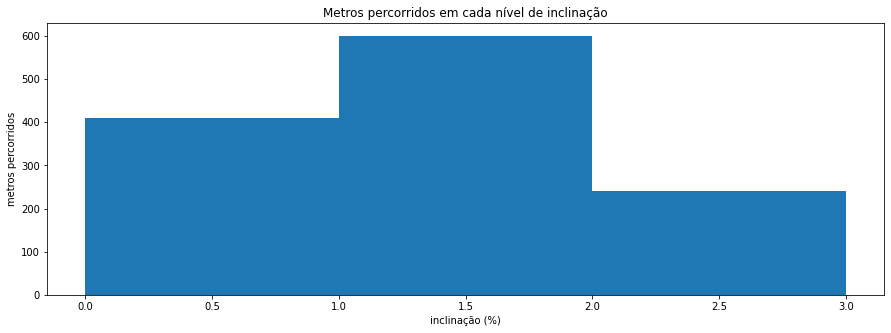

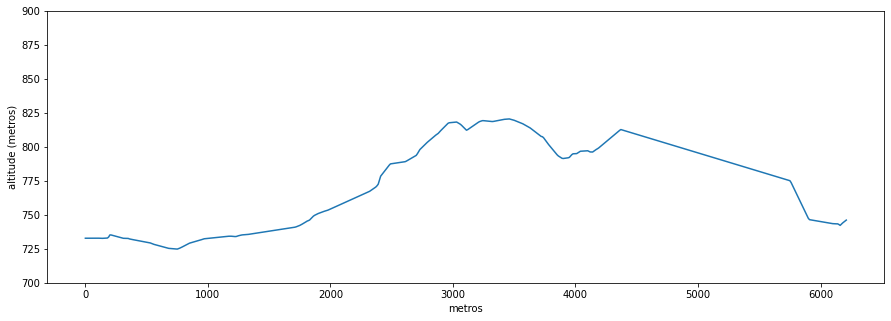

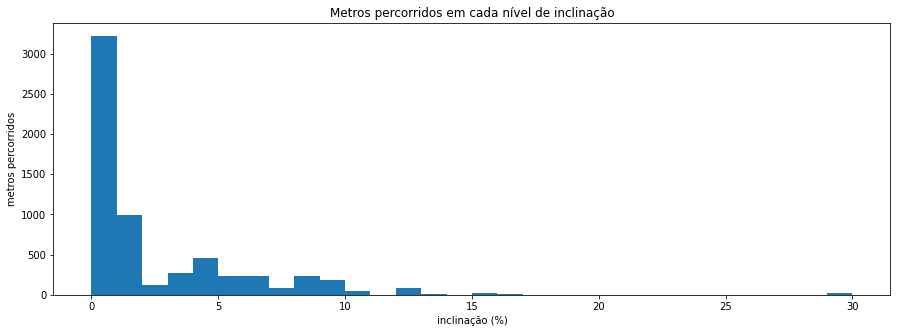

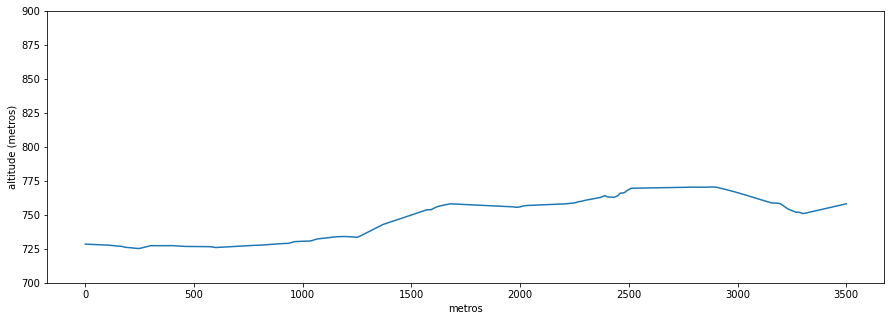

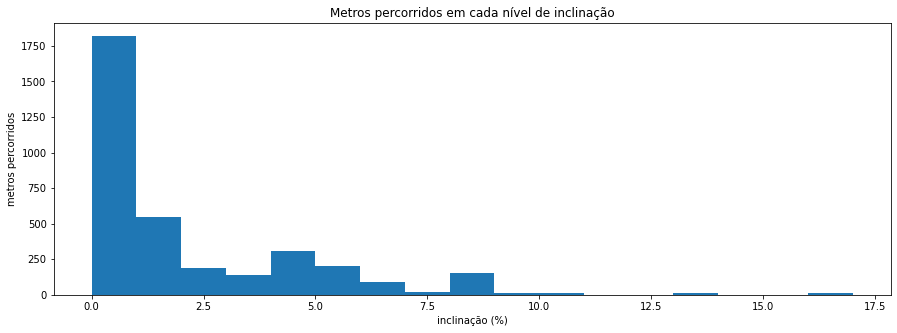

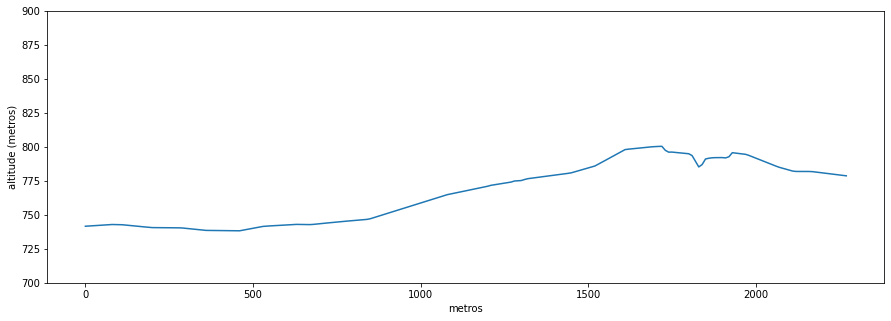

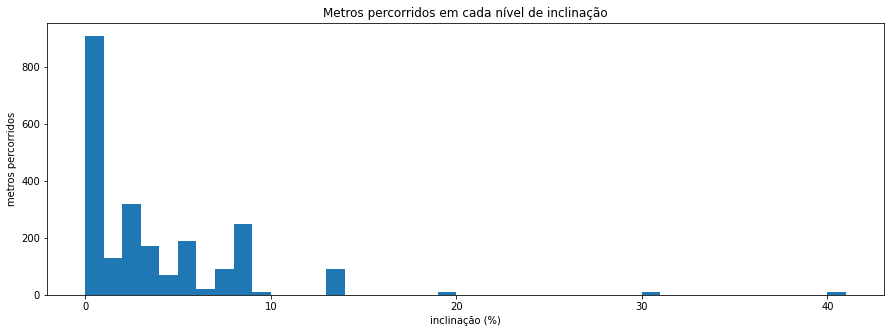

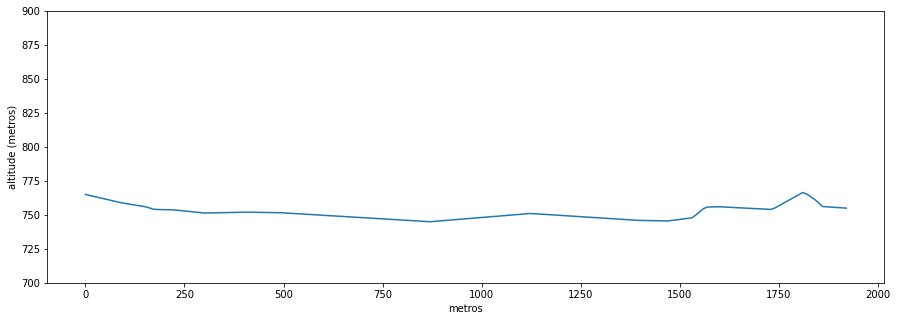

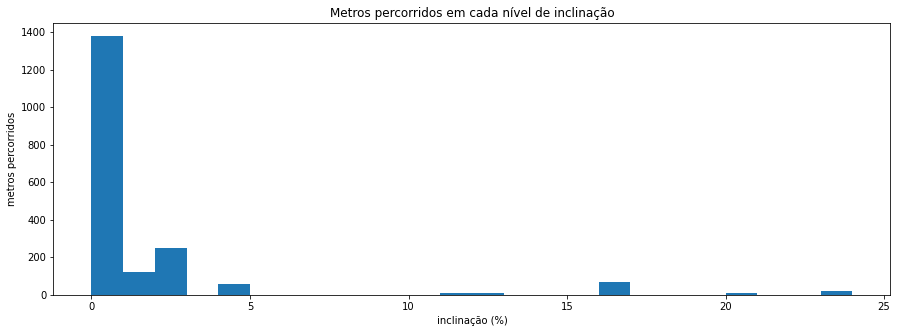

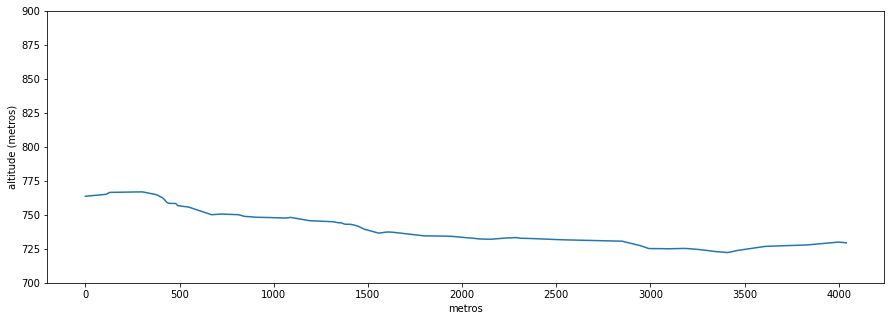

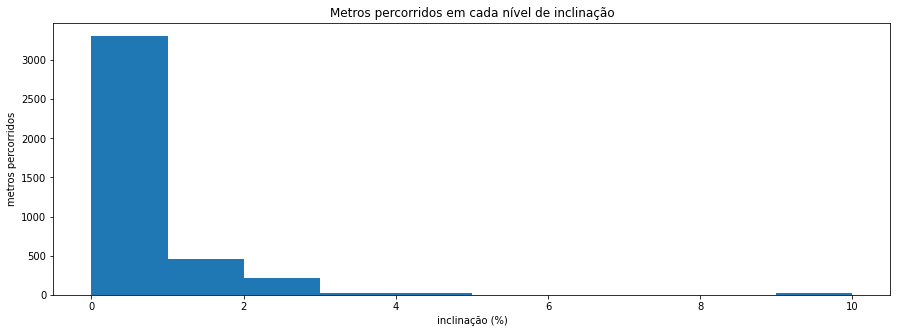

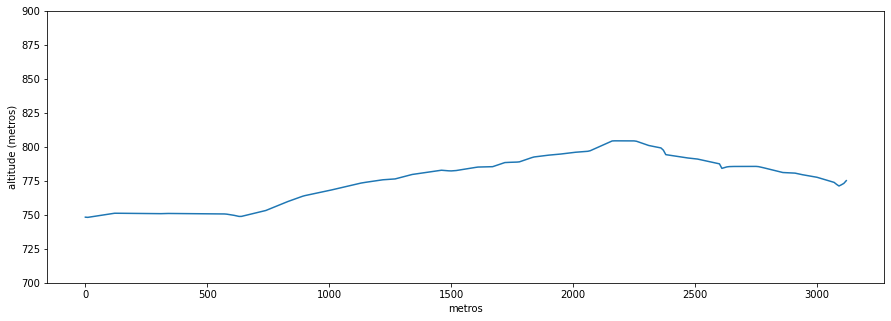

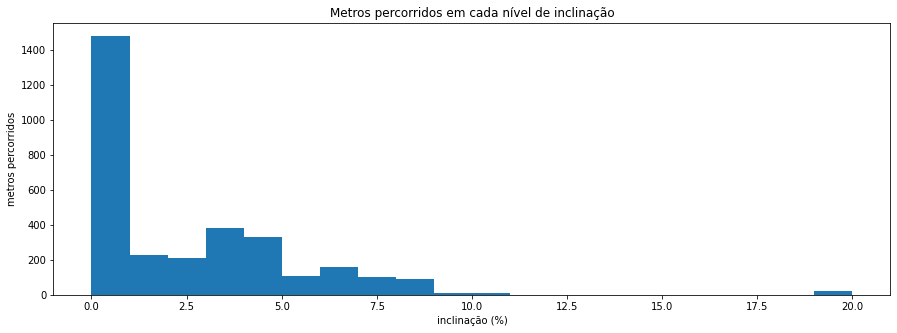

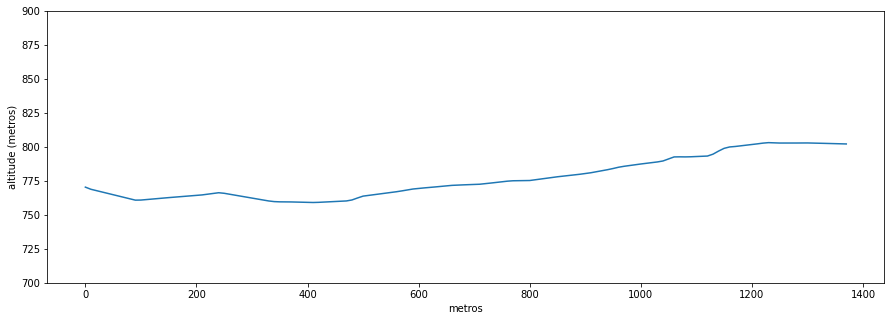

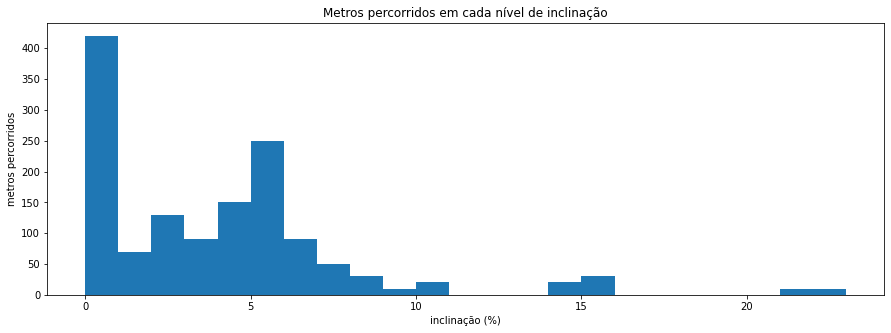

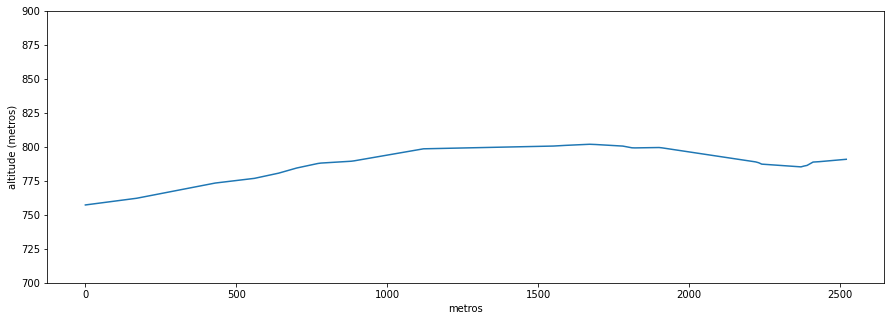

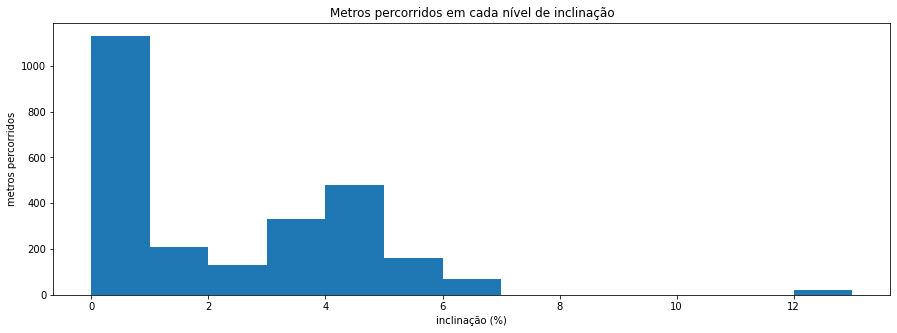

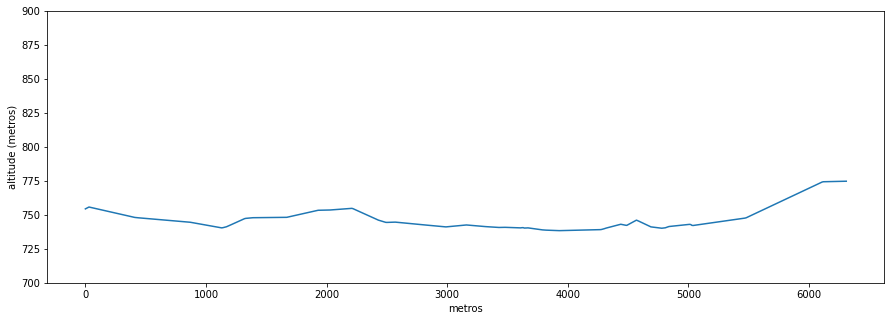

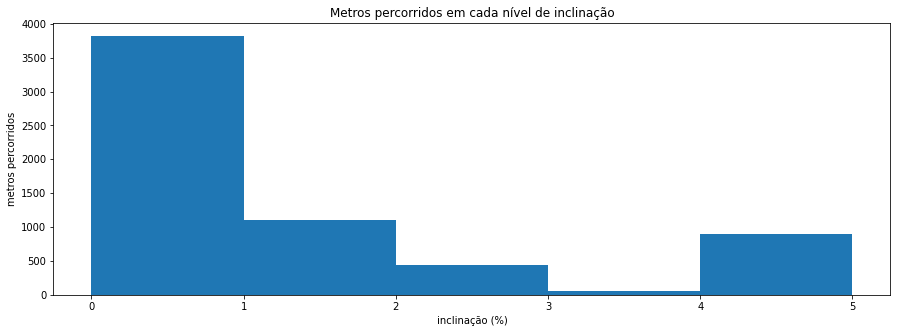

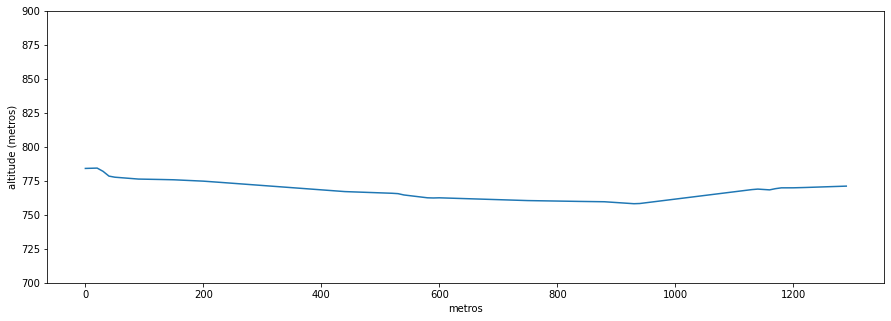

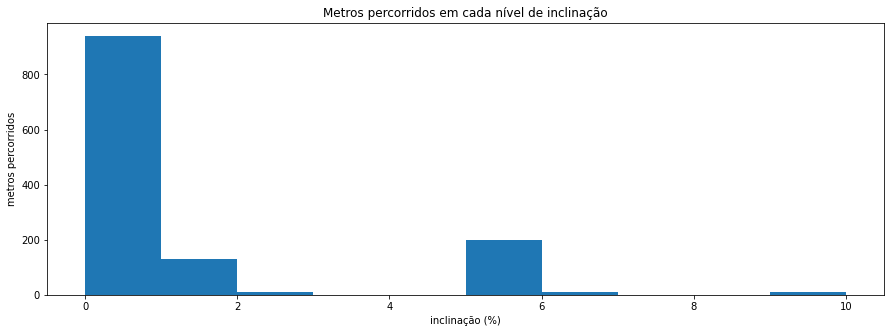

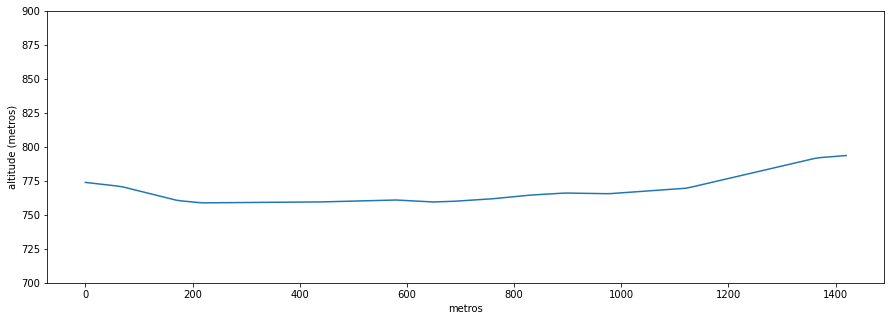

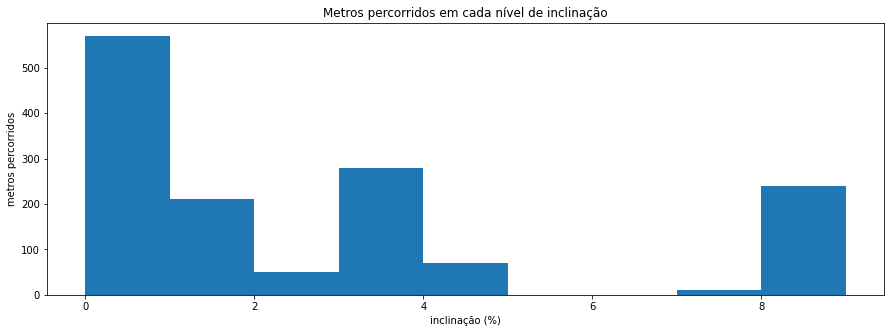

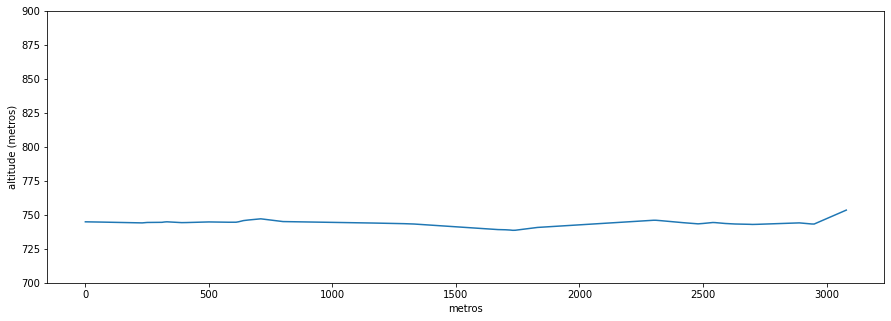

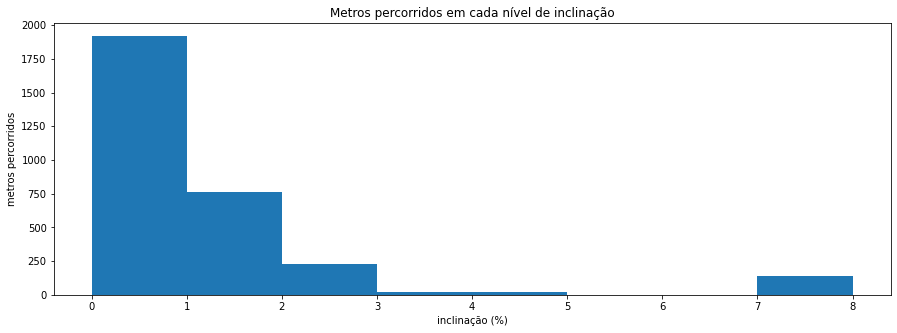

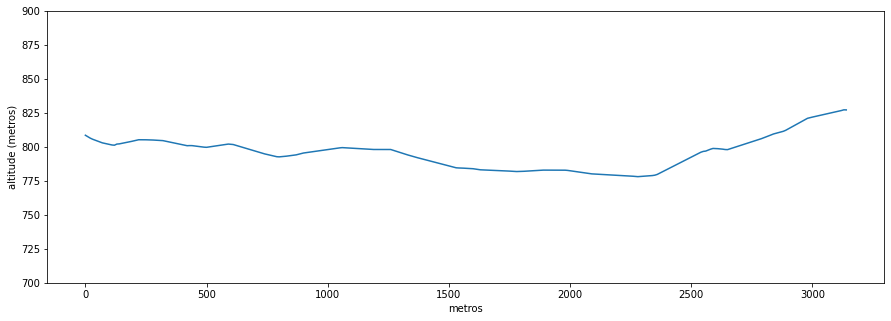

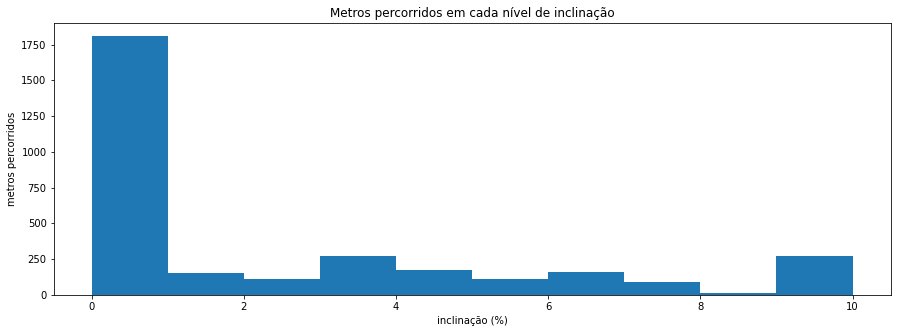

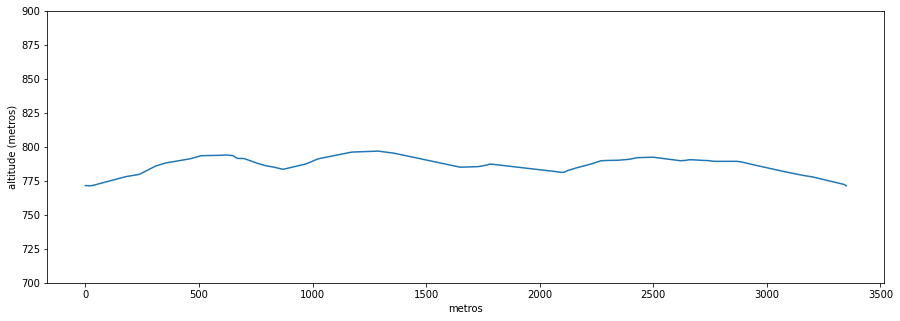

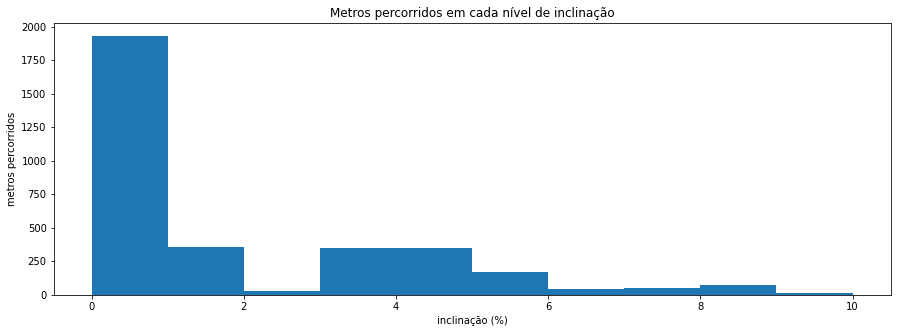

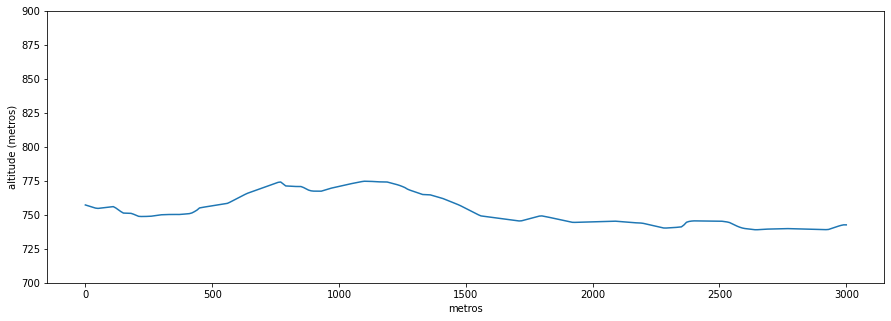

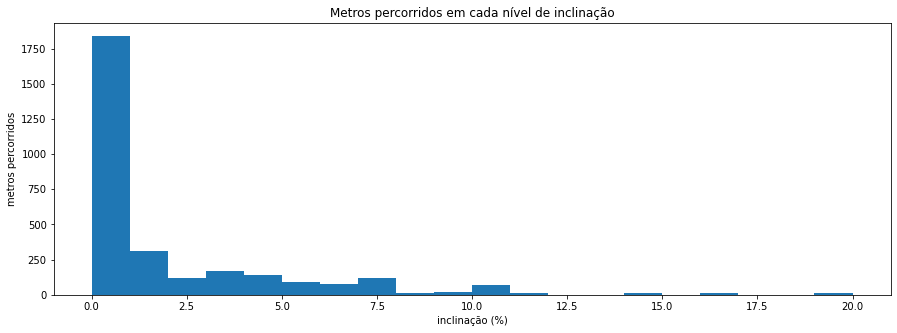

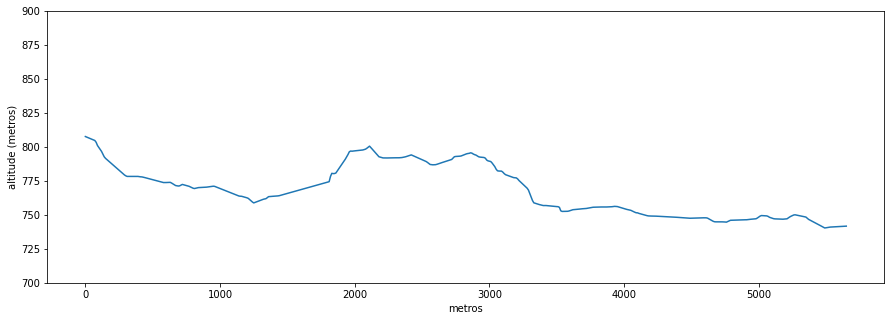

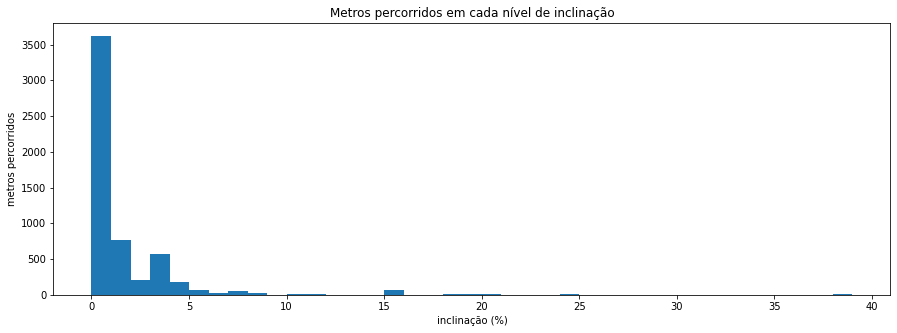

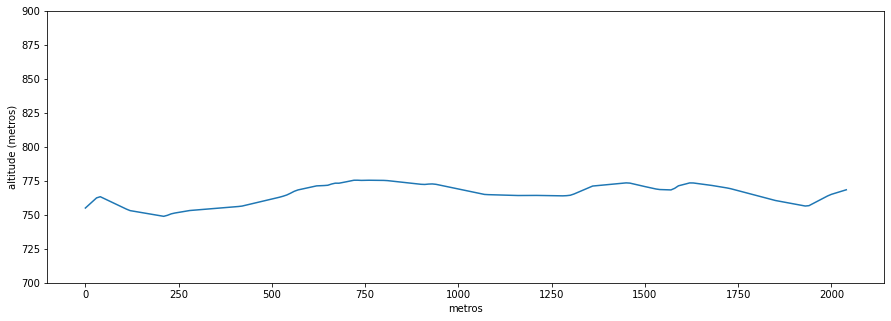

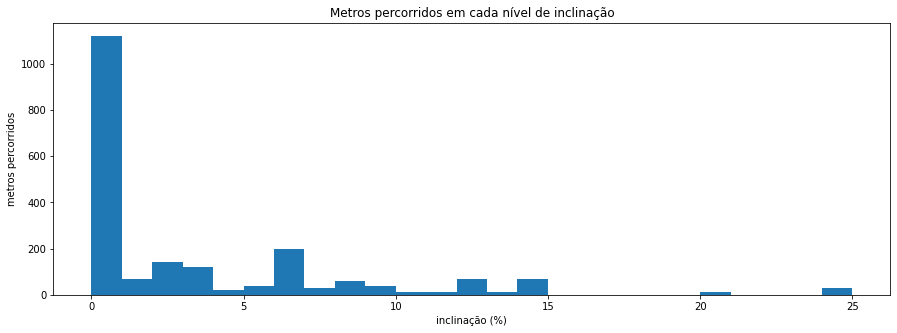

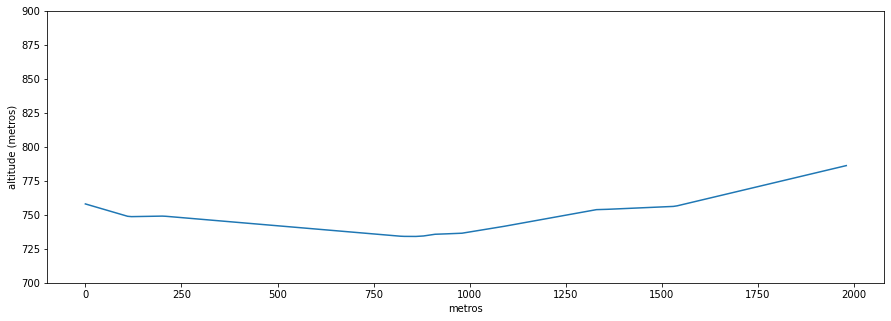

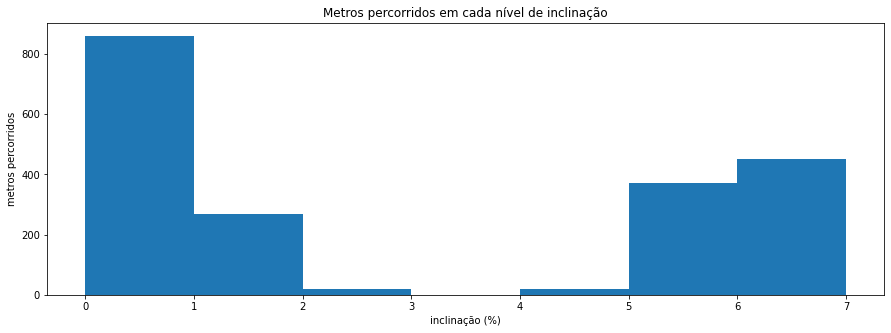

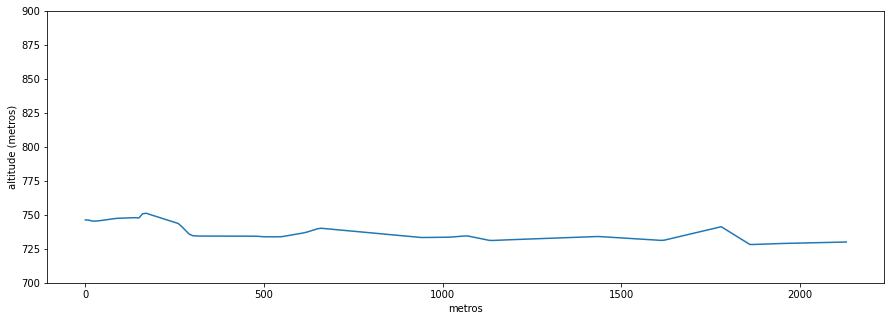

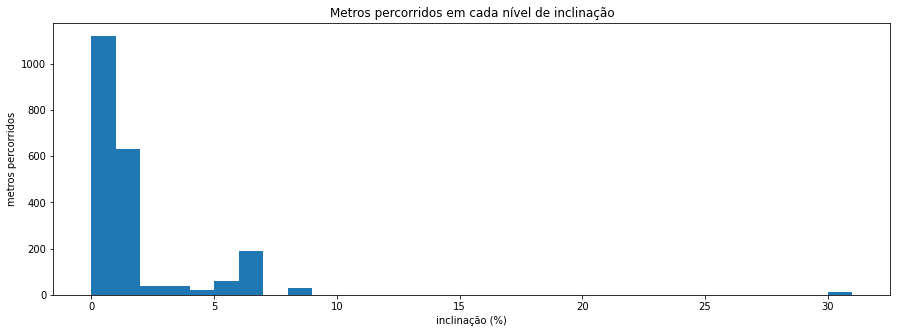

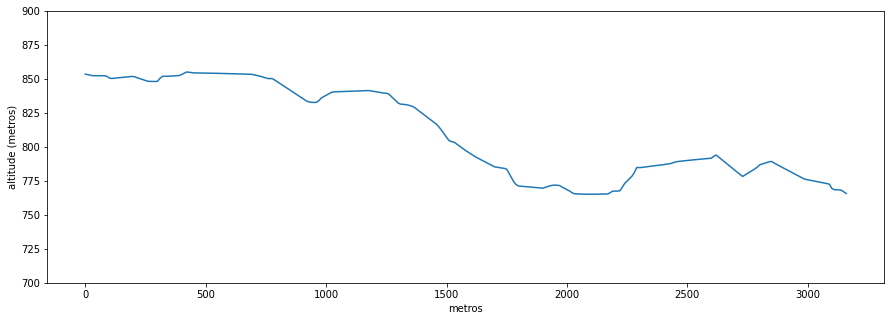

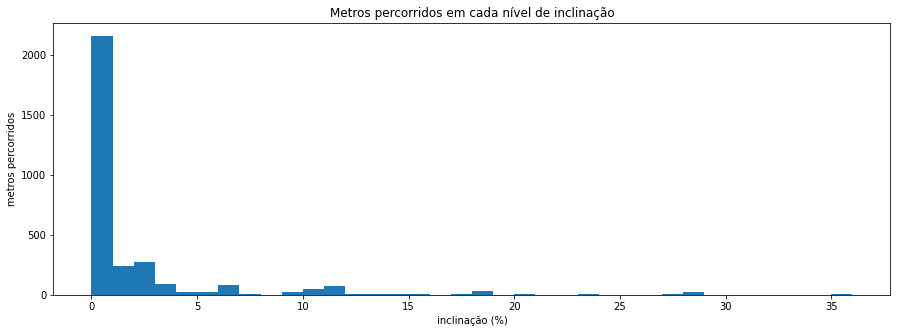

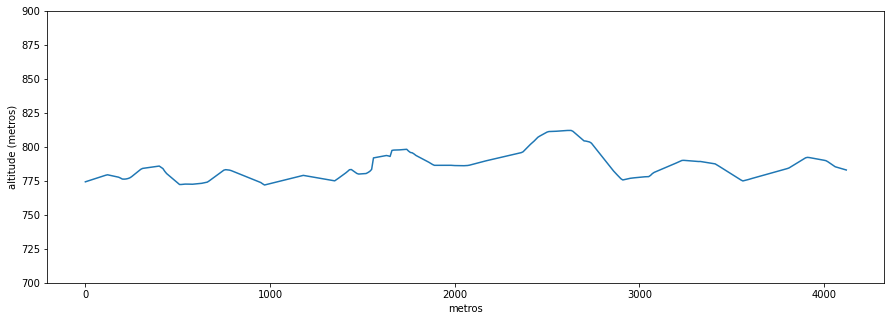

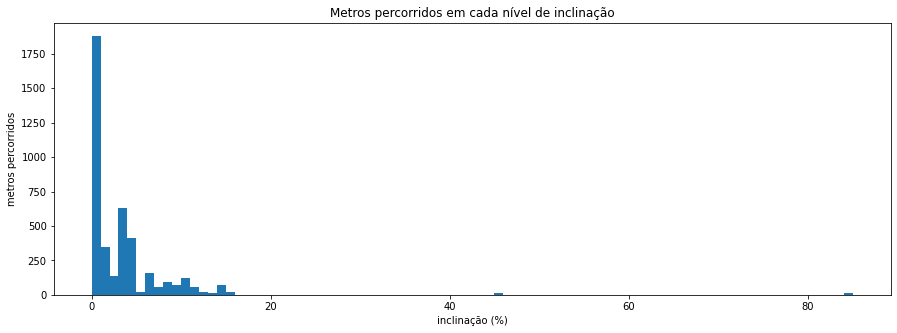

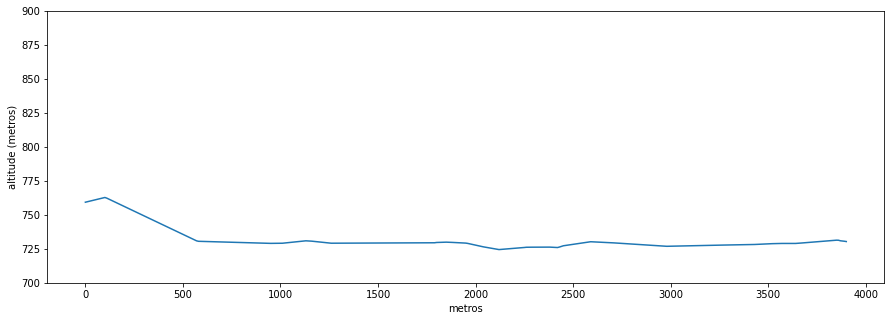

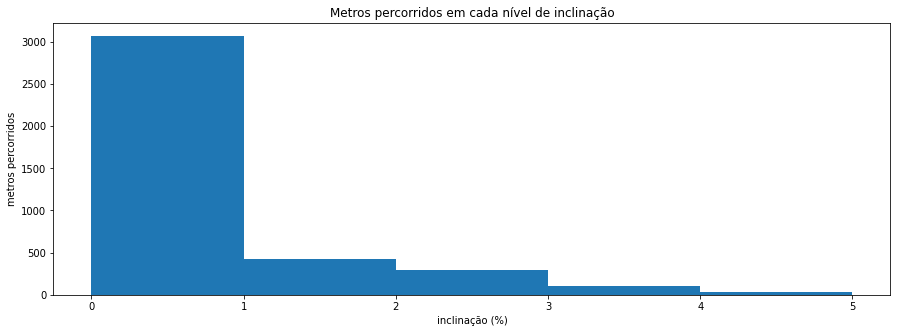

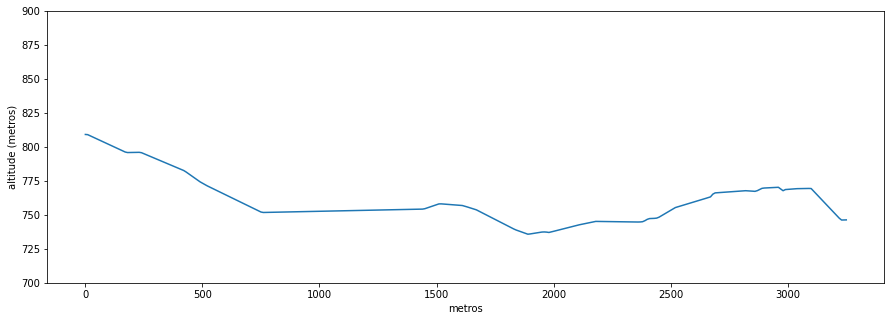

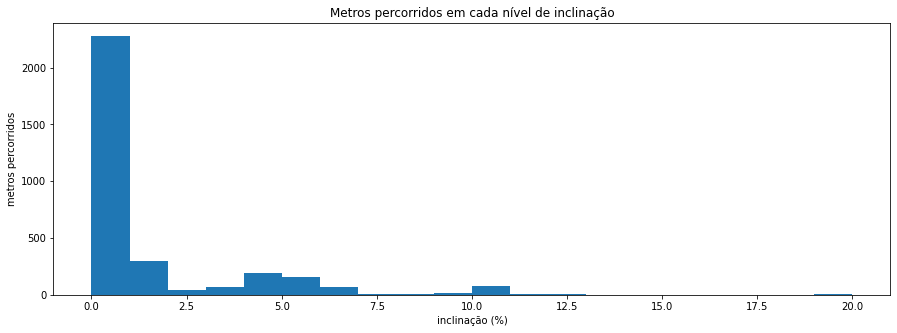

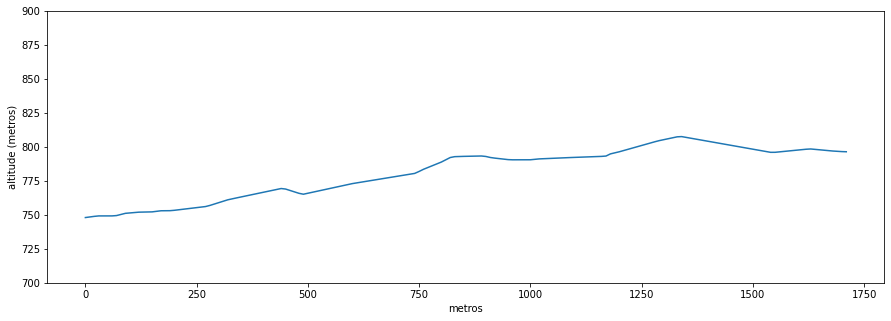

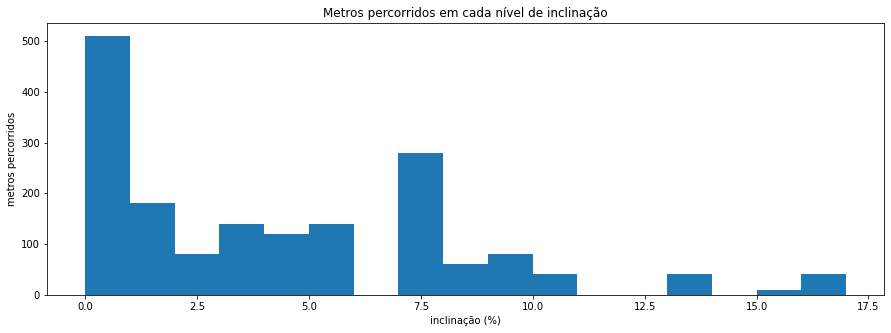

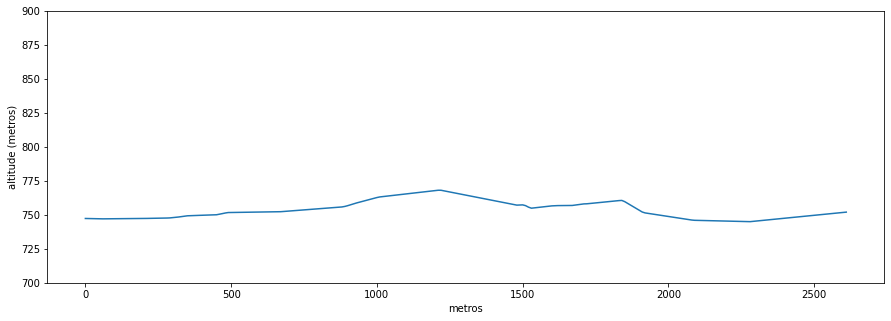

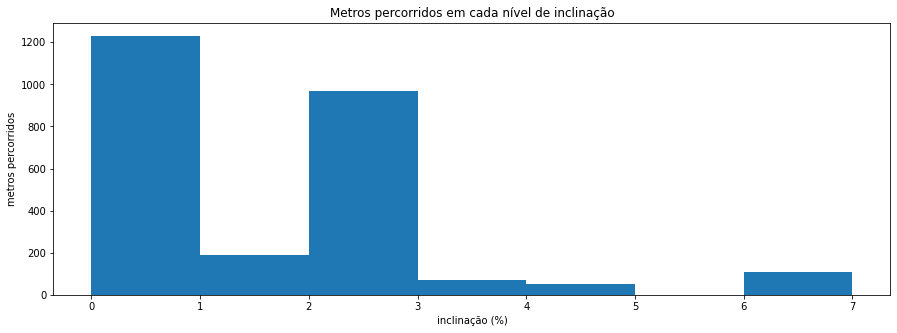

In [14]:
save_image (sul1)
save_image (sul2)
save_image (centro)
save_image (oeste)
save_image (leste1)
save_image (leste2)
save_image (norte1)
save_image (norte2)